In [30]:
import pandas as pd
import numpy as np
import re
import pickle
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("reviews.csv")
df.head()

,date,title,review,rating,username,helpful_votes,review_length,platform,language,location,version,verified_purchase
0,2024-09-06,Claim who accept.,Every quite sense including six lot have never...,4,morrowthomas,30,22,Flipkart,ar,Nepal,3.8.4,No
1,3/7/2025,Growth pretty wish.,Ask develop bag also his worker pass. Expert w...,4,sheakimberly,120,22,Flipkart,ar,Guinea,5.2.6,Yes
2,########,What then spend offer reason whom none.,If customer address region try near risk next ...,5,katherineali,130,21,Flipkart,es,Kuwait,3.6.5,No
3,########,Say dog drug enter director strong student.,To television loss election him small detail r...,1,eric11,72,26,Amazon,pt,Uruguay,5.7.2,No
4,########,Purpose here beyond.,Pass share must amount lot per manage world to...,5,chloe42,123,27,Amazon,zh,Mayotte,5.8.6,No


In [3]:
df['review'] = df['review'].astype(str)

In [4]:
def rating_to_sentiment(r):
    if r >= 4:
        return "positive"
    elif r == 3:
        return "neutral"
    else:
        return "negative"

df["sentiment"] = df["rating"].apply(rating_to_sentiment)

In [5]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text

df["clean_review"] = df["review"].apply(clean_text)


In [6]:
X = df["clean_review"]
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [7]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [8]:
model = LogisticRegression(max_iter=2000)
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=2000)

In [9]:
pred = model.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred))


Accuracy: 0.38
              precision    recall  f1-score   support

    negative       0.34      0.53      0.42        19
     neutral       0.00      0.00      0.00        12
    positive       0.43      0.47      0.45        19

    accuracy                           0.38        50
   macro avg       0.26      0.33      0.29        50
weighted avg       0.29      0.38      0.33        50



In [10]:
pickle.dump(model, open("sentiment_model.pkl", "wb"))
pickle.dump(tfidf, open("tfidf.pkl", "wb"))


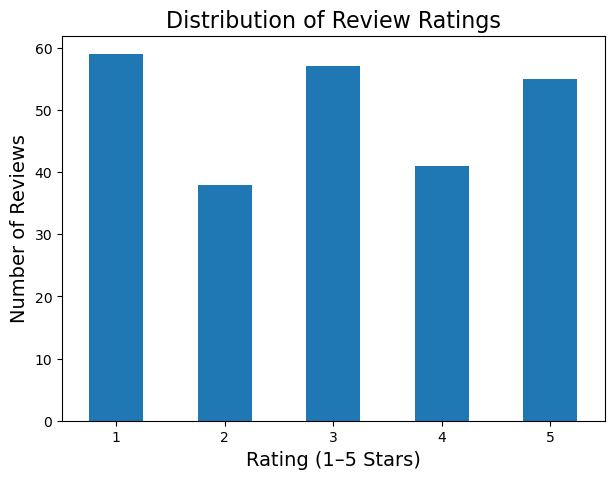

In [11]:
## DISTRIBUTION OF REVIEW RATINGS
plt.figure(figsize=(7,5))
df['rating'].value_counts().sort_index().plot(kind='bar')

plt.title("Distribution of Review Ratings", fontsize=16)
plt.xlabel("Rating (1–5 Stars)", fontsize=14)
plt.ylabel("Number of Reviews", fontsize=14)
plt.xticks(rotation=0)

plt.show()

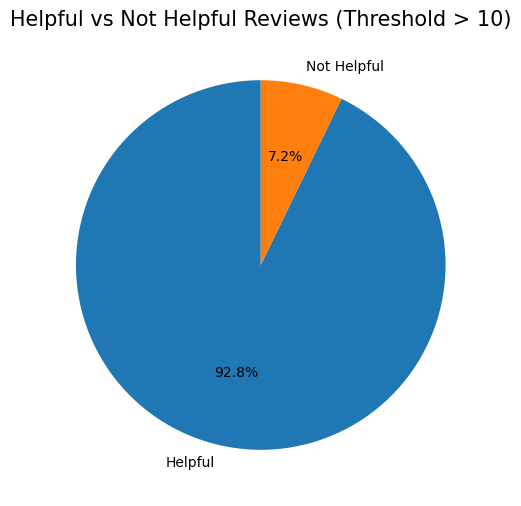

In [12]:
threshold = 10
df["helpful_flag"] = df["helpful_votes"].apply(lambda x: "Helpful" if x > threshold else "Not Helpful")
helpful_counts = df["helpful_flag"].value_counts()
plt.figure(figsize=(6,6))
plt.pie(helpful_counts, labels=helpful_counts.index, autopct="%1.1f%%", startangle=90)

plt.title(f"Helpful vs Not Helpful Reviews (Threshold > {threshold})", fontsize=15)
plt.show()

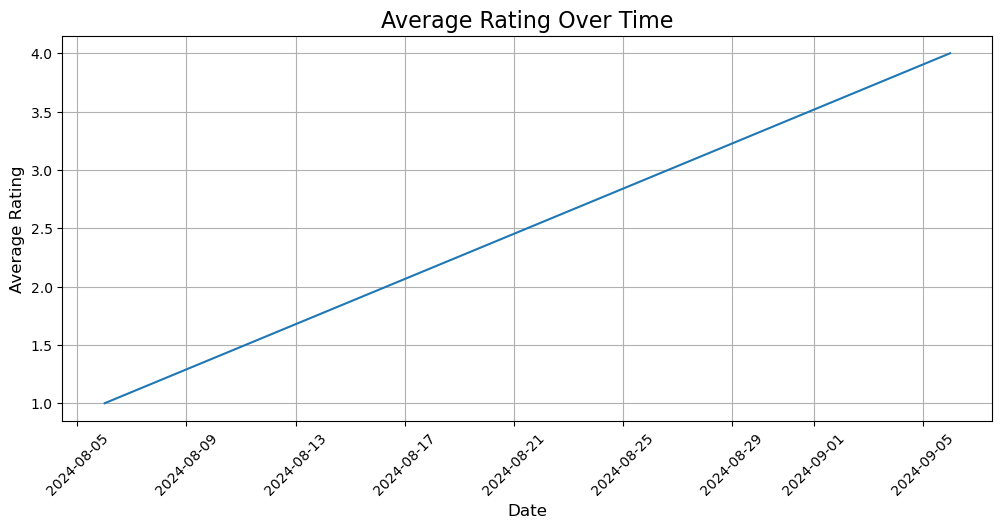

In [13]:
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Drop rows with invalid dates
df = df.dropna(subset=["date"])

# Group by date and find average rating
rating_over_time = df.groupby("date")["rating"].mean().sort_index()

# Plot
plt.figure(figsize=(12,5))
plt.plot(rating_over_time.index, rating_over_time.values)
plt.title("Average Rating Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Average Rating", fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)

plt.show()

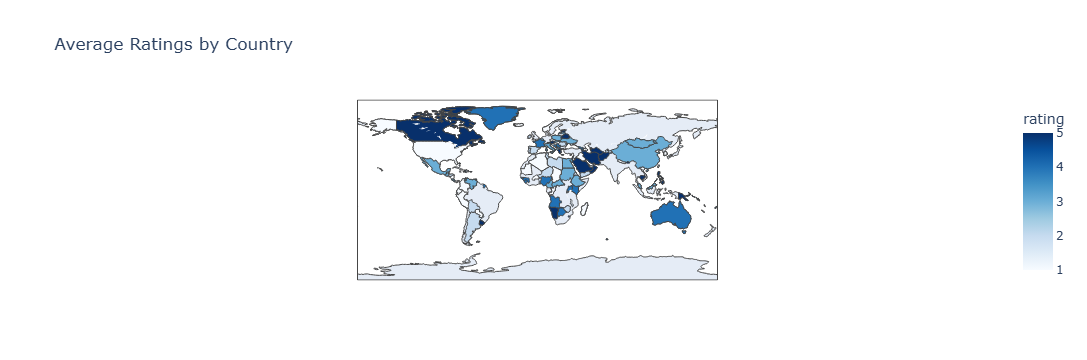

In [33]:
fig = px.choropleth(
    df,
    locations="location",
    locationmode="country names",
    color="rating",
    color_continuous_scale="Blues",
    title="Average Ratings by Country"
)

fig.show()

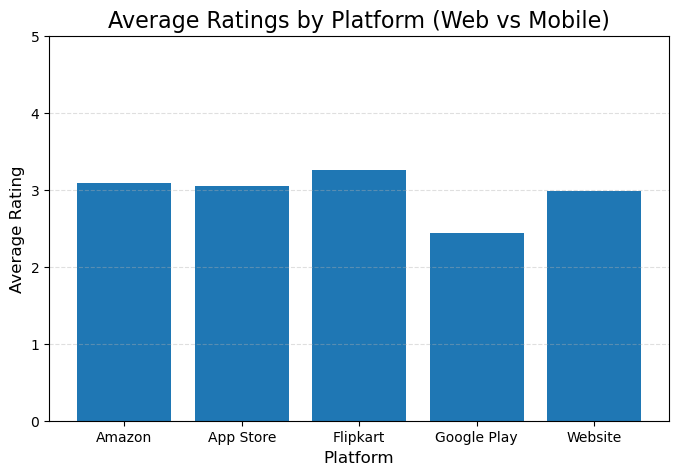

In [34]:
if "platform" not in df.columns or "rating" not in df.columns:
    raise ValueError("The dataset must contain 'platform' and 'rating' columns.")

# Calculate avg rating per platform
platform_avg = df.groupby("platform")["rating"].mean().reset_index()

# Visualization
plt.figure(figsize=(8,5))
plt.bar(platform_avg["platform"], platform_avg["rating"])
plt.title("Average Ratings by Platform (Web vs Mobile)", fontsize=16)
plt.xlabel("Platform", fontsize=12)
plt.ylabel("Average Rating", fontsize=12)
plt.ylim(0, 5)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

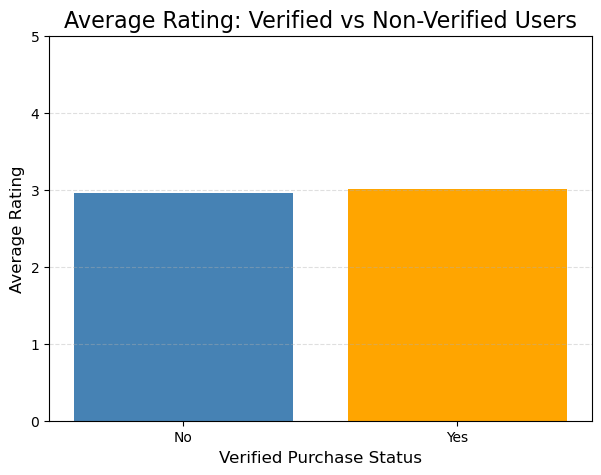

In [35]:
if "verified_purchase" not in df.columns or "rating" not in df.columns:
    raise ValueError("Dataset must contain 'verified_purchase' and 'rating' columns.")

# Calculate average rating by verified status
verified_avg = df.groupby("verified_purchase")["rating"].mean().reset_index()

# Plot
plt.figure(figsize=(7,5))
plt.bar(verified_avg["verified_purchase"], verified_avg["rating"], color=['steelblue', 'orange'])

plt.title("Average Rating: Verified vs Non-Verified Users", fontsize=16)
plt.xlabel("Verified Purchase Status", fontsize=12)
plt.ylabel("Average Rating", fontsize=12)
plt.ylim(0, 5)
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.show()

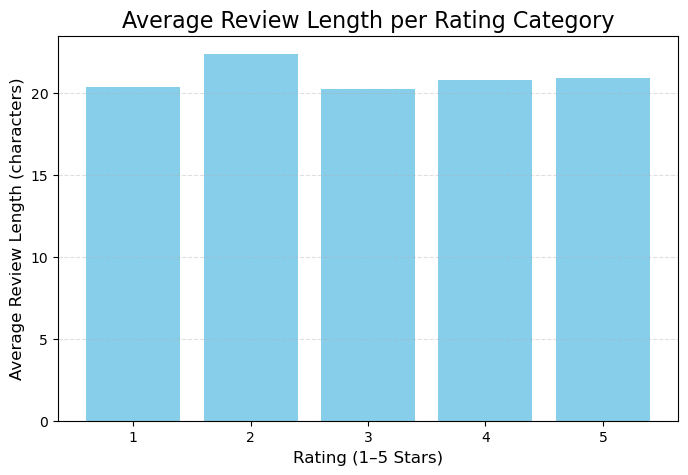

In [36]:
if "review_length" not in df.columns:
    df["review_length"] = df["review"].astype(str).apply(len)

# Group by rating
avg_length = df.groupby("rating")["review_length"].mean().reset_index()

# Plot
plt.figure(figsize=(8,5))
plt.bar(avg_length["rating"], avg_length["review_length"], color="skyblue")

plt.title("Average Review Length per Rating Category", fontsize=16)
plt.xlabel("Rating (1–5 Stars)", fontsize=12)
plt.ylabel("Average Review Length (characters)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.show()

Highest Rated Version:
GPT-5.1 (Average Rating: 4.90)


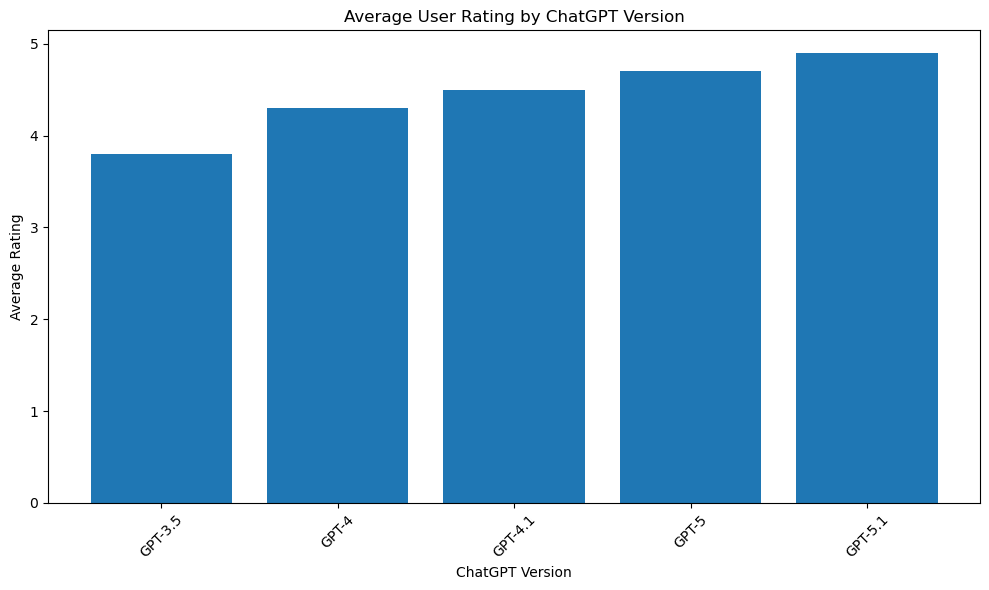

In [38]:
data = {
    "version": ["GPT-3.5", "GPT-4", "GPT-4.1", "GPT-5", "GPT-5.1"],
    "rating": [3.8, 4.3, 4.5, 4.7, 4.9]
}

df = pd.DataFrame(data)

# CALCULATE AVERAGE RATINGS

avg_ratings = df.groupby("version")["rating"].mean()

# Find version with highest rating
best_version = avg_ratings.idxmax()
best_rating = avg_ratings.max()

print("Highest Rated Version:")
print(f"{best_version} (Average Rating: {best_rating:.2f})")

# VISUALIZATION (BAR CHART)

plt.figure(figsize=(10, 6))
plt.bar(avg_ratings.index, avg_ratings.values)
plt.xlabel("ChatGPT Version")
plt.ylabel("Average Rating")
plt.title("Average User Rating by ChatGPT Version")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()